Import data and select relevant columns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

In [2]:
# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()
df.head()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
0,0,1,5,6,5,3,6,4,5,4,...,3,3,3,1,1,2,2,1,1,2
1,1,1,5,3,5,5,6,4,5,5,...,0,0,0,0,0,0,2,0,0,0
2,1,1,5,5,6,5,5,6,4,5,...,3,2,3,2,2,1,3,2,2,2
3,1,1,6,6,6,6,5,6,6,6,...,2,1,1,0,0,1,1,1,1,3
4,0,1,4,6,6,6,3,6,4,5,...,3,3,2,2,2,3,1,0,0,1


Data preprocessing

In [3]:
# gender split of the dataset
print(f"Gender split before balancing the dataset: {len(df[df['gender'] == 0])} women to {len(df[df['gender'] == 1])} men.")

Gender split before balancing the dataset: 177 women to 43 men.


Balancing the dataset using oversampling techniques

In [4]:
# balance the dataset in regards to gender while keeping the same statistical properties
smote = SMOTE(k_neighbors=5, random_state=38)
adasyn = ADASYN(random_state=38)

X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0

Check whether SMOTE or ADASYN is better suited for oversampling the dataset

In [5]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)
# oversample the training set using SMOTE
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
# oversample the training set using ADASYN
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

classifiers = {
    "Random Forest": RandomForestClassifier(random_state=38),
    "Logistic Regression": LogisticRegression(random_state=38, max_iter=1000),
    "Support Vector Machine": SVC(random_state=38)
}

# smote
for name, classifier in classifiers.items():
    classifier.fit(X_resampled_smote, y_resampled_smote)
    y_pred = classifier.predict(X_test)
    print(f'SMOTE: Classification report for {name}.')
    print(classification_report(y_test, y_pred))

print('------------------------------------------------------------')

# adasyn
for name, classifier in classifiers.items():
    classifier.fit(X_resampled_adasyn, y_resampled_adasyn)
    y_pred = classifier.predict(X_test)
    print(f'ADASYN: Classification report for {name}.')
    print(classification_report(y_test, y_pred))

SMOTE: Classification report for Random Forest.
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        56
           1       0.36      0.40      0.38        10

    accuracy                           0.80        66
   macro avg       0.63      0.64      0.63        66
weighted avg       0.81      0.80      0.81        66

SMOTE: Classification report for Logistic Regression.
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        56
           1       0.35      0.70      0.47        10

    accuracy                           0.76        66
   macro avg       0.64      0.73      0.65        66
weighted avg       0.85      0.76      0.79        66

SMOTE: Classification report for Support Vector Machine.
              precision    recall  f1-score   support

           0       0.95      0.73      0.83        56
           1       0.35      0.80      0.48        10

    accuracy           

ADASYN generally shows better performance in terms of precision, recall, and F1-score compared to SMOTE across all classifiers (Random Forest, Logistic Regression, Support Vector Machine)

It also achieves higher accuracy and better balance between precision and recall for both classes compared to SMOTE, indicating its effectiveness in handling the class imbalance

Apply ADASYN to the dataset

In [6]:
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
# gender split of the dataset
print(f"Gender split after balancing the dataset: {len(balanced_df[balanced_df['gender'] == 0])} women to {len(balanced_df[balanced_df['gender'] == 1])} men.")
balanced_df.describe()

Gender split after balancing the dataset: 177 women to 179 men.


,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.457865,3.542135,3.702247,4.794944,4.379213,3.870787,3.735955,3.292135,4.308989,...,1.553371,1.390449,1.294944,0.988764,0.761236,1.415730,1.595506,1.109551,1.033708,1.176966
std,0.500696,0.498923,1.587245,1.536814,1.430090,1.470658,1.581634,1.652297,1.693083,1.622041,...,1.020889,0.879705,0.961265,0.987178,0.820005,1.027059,0.975406,1.043730,1.025857,1.071857
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Train, test split of the balanced dataset

In [7]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

In [8]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

In [9]:
X_train_val = pd.concat([X_train_val_women, X_train_val_men])
y_train_val = pd.concat([y_train_val_women, y_train_val_men])

Feature selection

In [10]:
# number of features in the resulting questionnaire
feature_num = 20
# number of features to get through filter methods
filter_features_num = 30

In [11]:
# pTRAQ questions
# load the pTRAQ questions description CSV dataset file into a DataFrame
ptraq_questions = pd.read_csv('pTRAQ_questions.csv', sep=';')
# drop last row
ptraq_questions.drop(ptraq_questions.index[-1], inplace=True) 

In [12]:
# add a column corresponding to the questionnaire dataset 
ptraq_questions = ptraq_questions.assign(question_code=[f'tr{i}' for i in range(1,43+1)])

In [13]:
dsm5_criteria = pd.read_csv('DSM5_ADHD_criteria.csv', sep=';')
# add columns with corresponding DSM-5 criteria and symptom category to pTRAQ questions
ptraq_questions = ptraq_questions.assign(dsm5_criteria=[c for c in dsm5_criteria['criteria_text']])
ptraq_questions = ptraq_questions.assign(symptom_category=[c for c in dsm5_criteria['category']])
#ptraq_questions.head()

Filter methods

Point Biserial Correlation

In [14]:
# get correlation of tr questions (1-6) to adhd diagnosis (0, 1)
# adhd group 1
# non-adhd group 0

# all data
question_cols = balanced_df.filter(regex='^tr\d+$').columns
correlations = []
p_values = []

for col in question_cols:
    corr, p_value = stats.pointbiserialr(balanced_df['group'], balanced_df[col])
    correlations.append(corr)
    p_values.append(p_value.round(3))

correlation_df = pd.DataFrame({
    'Question': question_cols,
    'Correlation': correlations,
    'P-value': p_values
})

corr_df = correlation_df.sort_values(by='Correlation', ascending=False)
corr_df = pd.merge(corr_df, ptraq_questions, left_on='Question', right_on='question_code', how='inner')
corr_df.drop(columns=['Question', 'Critère DSM-5','ID Critère','ID Projet', 'French Item (Validated)'])[:filter_features_num]

,Correlation,P-value,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,0.672552,0.0,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention
1,0.632489,0.0,I find it hard to stay in place when the situa...,tr33,Often unable to play or engage in leisure acti...,hyperactivity/impulsivity
2,0.618190,0.0,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity
3,0.612023,0.0,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention
4,0.581180,0.0,I often leave my seat unnecessarily during a m...,tr28,Often leaves seat in situations when remaining...,hyperactivity/impulsivity
5,0.580423,0.0,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
6,0.574133,0.0,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention
7,0.573525,0.0,I find it difficult to wait my turn in a conve...,tr40,Often blurts out an answer before a question h...,hyperactivity/impulsivity
8,0.570214,0.0,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention
9,0.566096,0.0,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention


Mutual Information

In [15]:
importances = []
features = []

mutual_info = mutual_info_classif(X_train, y_train)
for importance, feature in sorted(zip(mutual_info, X_train.columns), reverse=True):
    importances.append(importance)
    features.append(feature)

mutual_info_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

mutual_info_df[:filter_features_num]

,Feature,Importance
0,tr24,0.326708
1,tr4,0.302152
2,tr34,0.285072
3,tr1,0.254671
4,tr8,0.246053
5,tr33,0.243170
6,tr21,0.235035
7,tr28,0.234245
8,tr12,0.229143
9,tr40,0.213003


Wrapper methods

Resursive Feature Elimination

In [16]:
model = LogisticRegression(max_iter=500, random_state=15)

rfe = RFE(model, n_features_to_select=feature_num)
rfe.fit(X_train, y_train)

rfe_selected_features = X_train.columns[rfe.support_]
rfe_selected_features

Index(['tr1', 'tr3', 'tr4', 'tr6', 'tr8', 'tr9', 'tr11', 'tr13', 'tr17',
       'tr18', 'tr20', 'tr21', 'tr24', 'tr25', 'tr27', 'tr28', 'tr32', 'tr35',
       'tr41', 'tr43'],
      dtype='object')

Correlation matrix for features chosen with RFE

Text(0.5, 1.0, 'Correlation Matrix for features selected using RFE')

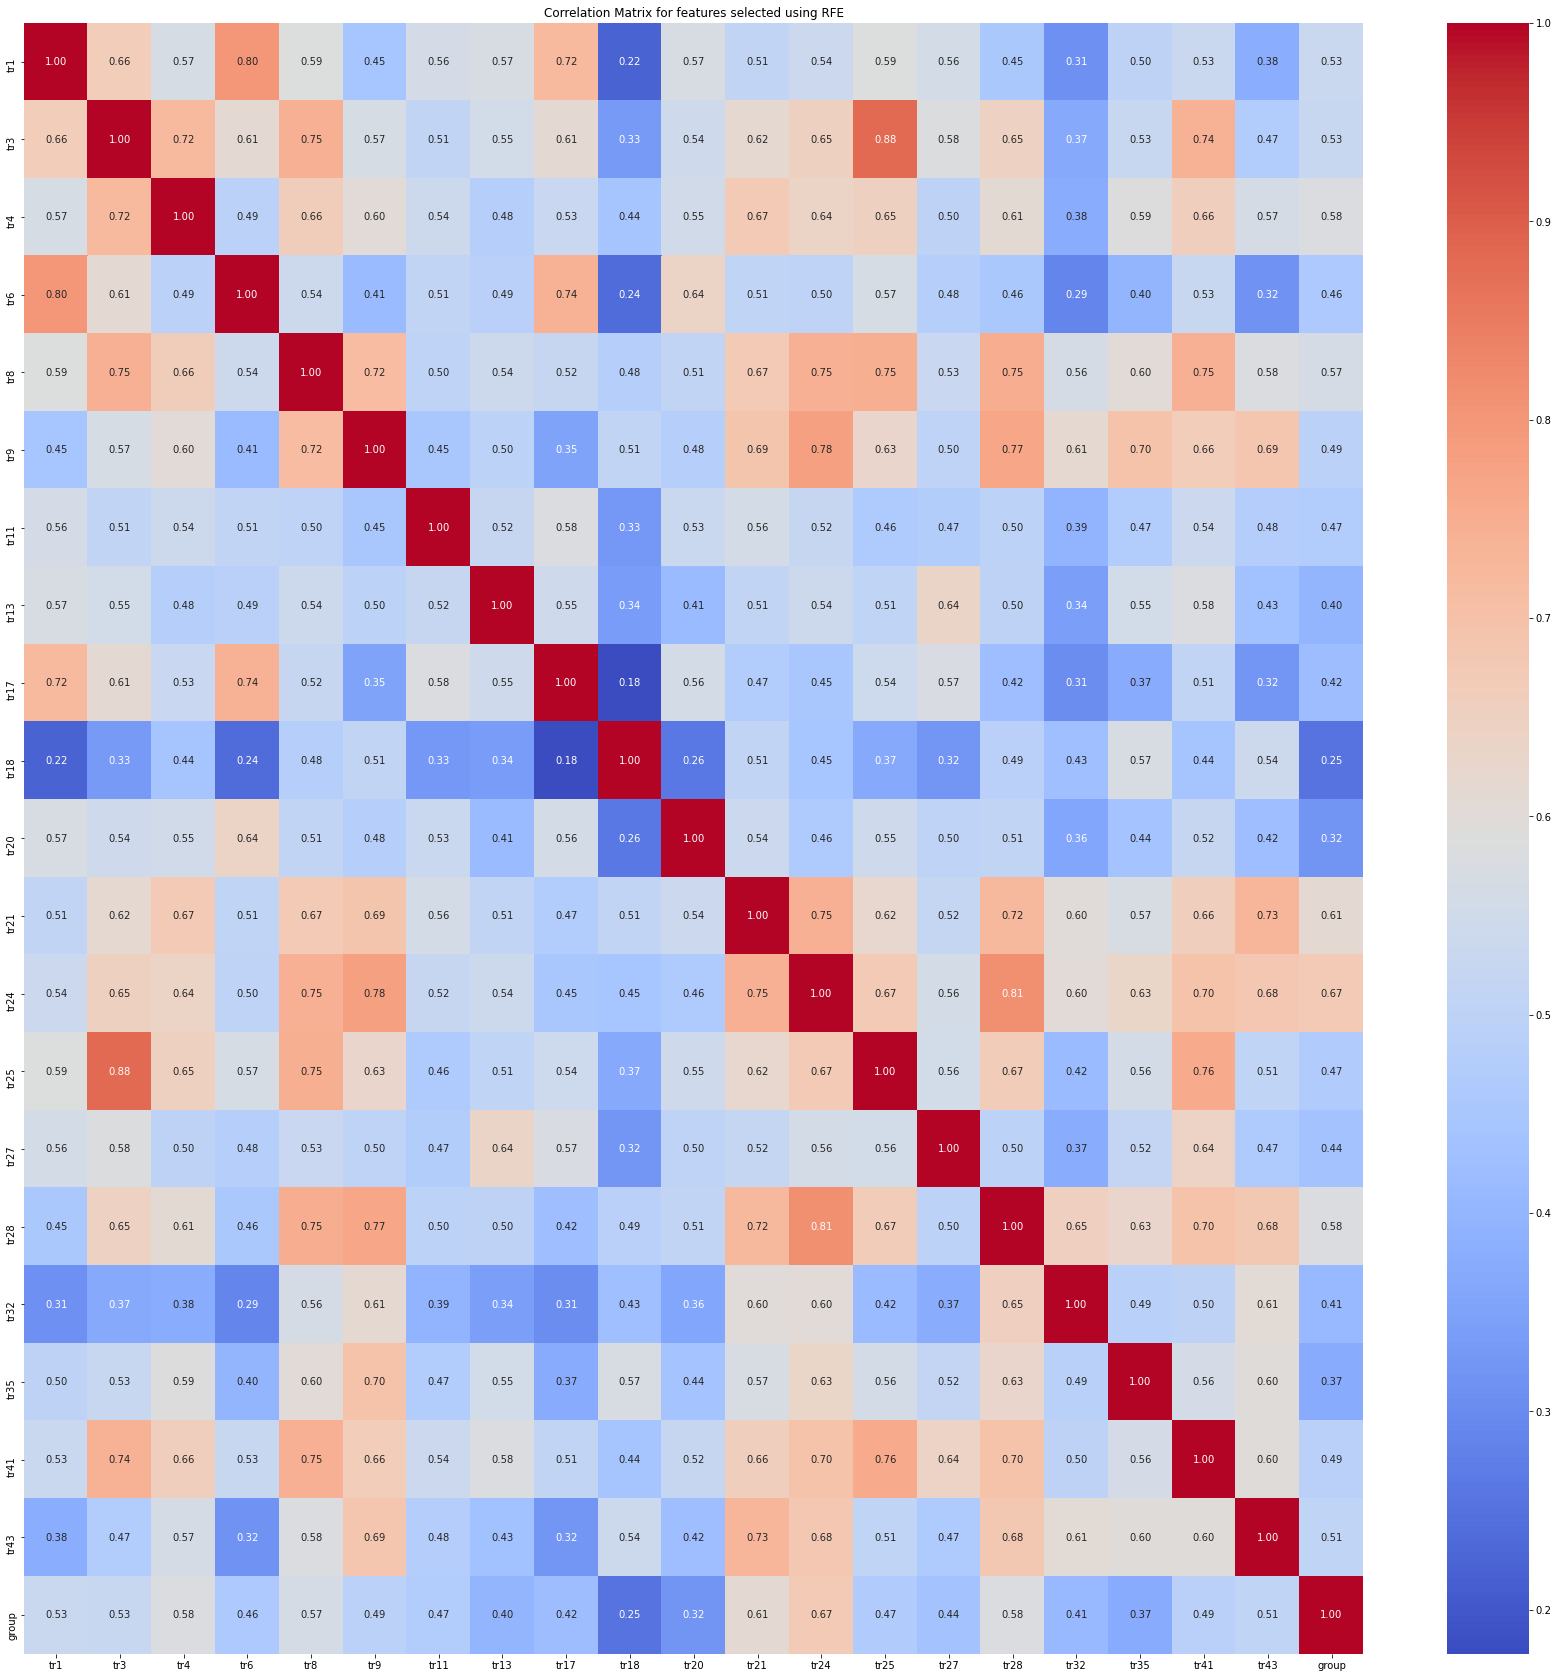

In [17]:
cols = rfe_selected_features.tolist() + ['group']
corr = balanced_df[cols].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for features selected using RFE')

Check for multicollinearity - calculate the variance inflation factor (VIF)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_train_selected = X_train.copy()[rfe_selected_features]

def calculate_vif(X):
    # X - dataframe with independent features
    X_constant = add_constant(X)
    # calculate vif
    vif_vals = pd.DataFrame()
    vif_vals['var'] = X_constant.columns
    vif_vals['vif'] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
    
    return vif_vals[vif_vals['var'] != 'const'].sort_values(by='vif', ascending=False)

vif_results = calculate_vif(X_train_selected)
# iterate until all VIF values are less than 5
while vif_results['vif'].max() > 5: 
    # find the column with the highest VIF
    max_vif_column = vif_results.loc[vif_results['vif'].idxmax(), 'var']
    print(f'dropping {max_vif_column}')
    # remove the column with the highest VIF
    X_train_selected = X_train_selected.drop(columns=[max_vif_column])
    # recalculate VIF
    vif_results = calculate_vif(X_train_selected)

vif_results.sort_values(by='vif', ascending=True)

dropping tr3
dropping tr24
dropping tr1


,var,vif
8,tr18,1.644971
14,tr32,2.212093
6,tr13,2.243551
5,tr11,2.362007
9,tr20,2.377710
12,tr27,2.646377
15,tr35,2.885879
17,tr43,3.084187
11,tr25,3.276691
7,tr17,3.322367


Resulting questionnaire

In [19]:
screening_features = rfe_selected_features

In [20]:
screening_questions = ptraq_questions.drop(columns=['ID Critère', 'ID Projet', 'French Item (Validated)'])

screening_questions = screening_questions[screening_questions['question_code'].isin(screening_features)]
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
2,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
3,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
5,B,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention
7,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
8,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
10,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
12,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention
16,F,I tend to operate at the last minute,tr17,"Often avoids, dislikes, or is reluctant to eng...",inattention
17,G (I),I often lose things I need for my daily life,tr18,Often loses things necessary for tasks or acti...,inattention


In [21]:
# save the questionnaire into a csv format
file_name = f'{feature_num}_screening_questions.csv'
screening_questions.to_csv(file_name, index=False, sep=';')